## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od zlokalizowania jakichś obiektów, być może z góry wiemy, gdzie obiekty się znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps (spowolnienie ok. 1:7.5) zostało przekodowane tak, aby osiągnąć zbieżność upływu czasu. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [ ]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem.

In [ ]:
shuttle = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/shuttle.mp4')

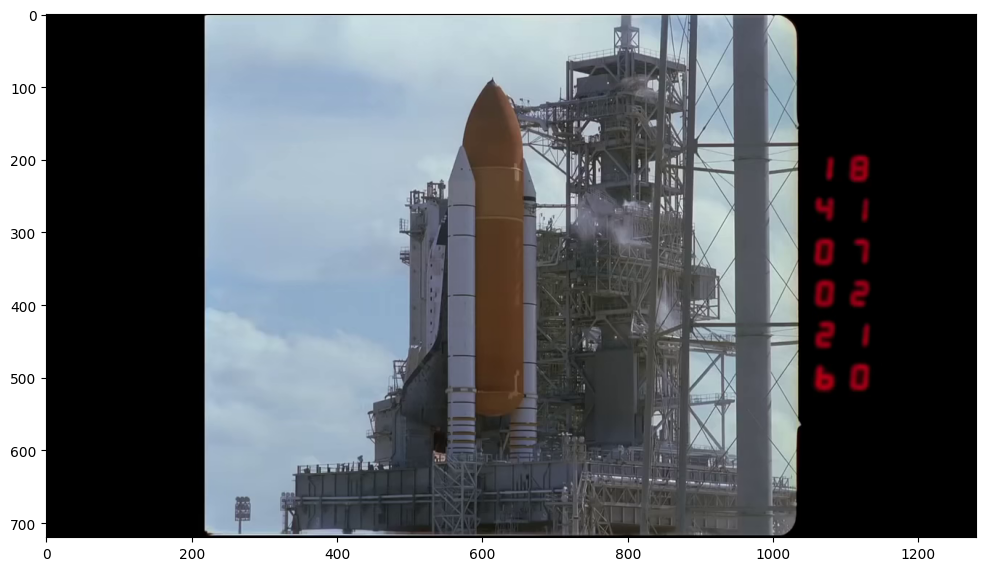

In [ ]:
status, frame = shuttle.read()
shuttle.release()
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

In [ ]:
from google.colab.patches import cv2_imshow

- maxCorners - Maximum number of corners to return. If there are more corners than are found, the strongest of them is returned. if <= 0 implies that no limit on the maximum is set and all detected corners are returned
- qualityLevel - Parameter characterizing the minimal accepted quality of image corners. Shi-Tomasi or Harris Corner
- minDistance - Minimum possible Euclidean distance between the returned corners


First, this function calculates the corner quality score at every pixel using either Shi-Tomasi or Harris Corner
Then this function performs a non-maximum suppression (the local maximums in 3 x 3 neighborhood are retained).
After this, all the corners with the quality score less than qualityLevel*maxx,yqualityScore(x,y) are rejected. This maxx,yqualityScore(x,y) is the best corner score. For instance, if the best corner has the quality score = 1500, and the qualityLevel=0.01 , then all the corners with the quality score less than 15 are rejected.
Now, all the remaining corners are sorted by the quality score in the descending order.
Function throws away each corner for which there is a stronger corner at a distance less than maxDistance.

In [ ]:
def find_features(img, max_corners, quality_level, min_distance):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  corners_float = cv2.goodFeaturesToTrack(gray_img, max_corners, quality_level, min_distance)
  corners = np.int0(corners_float)

  result_img = img.copy()
  for corner in corners:
      x, y = corner.ravel()
      cv2.circle(result_img, (x, y), 5, 255, -1)

  return corners_float, result_img

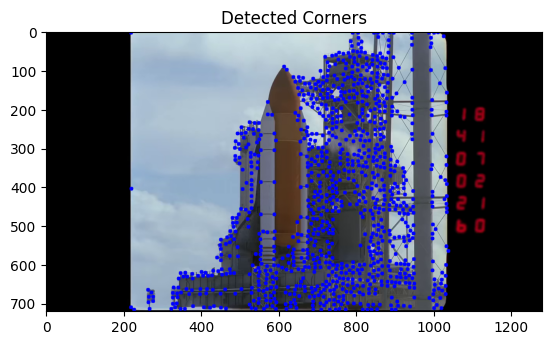

In [ ]:
c, res_frame = find_features(frame, 1000, 0.001, 10)

plt.imshow(cv2.cvtColor(res_frame, cv2.COLOR_BGR2RGB))
plt.title('Detected Corners')
plt.show()

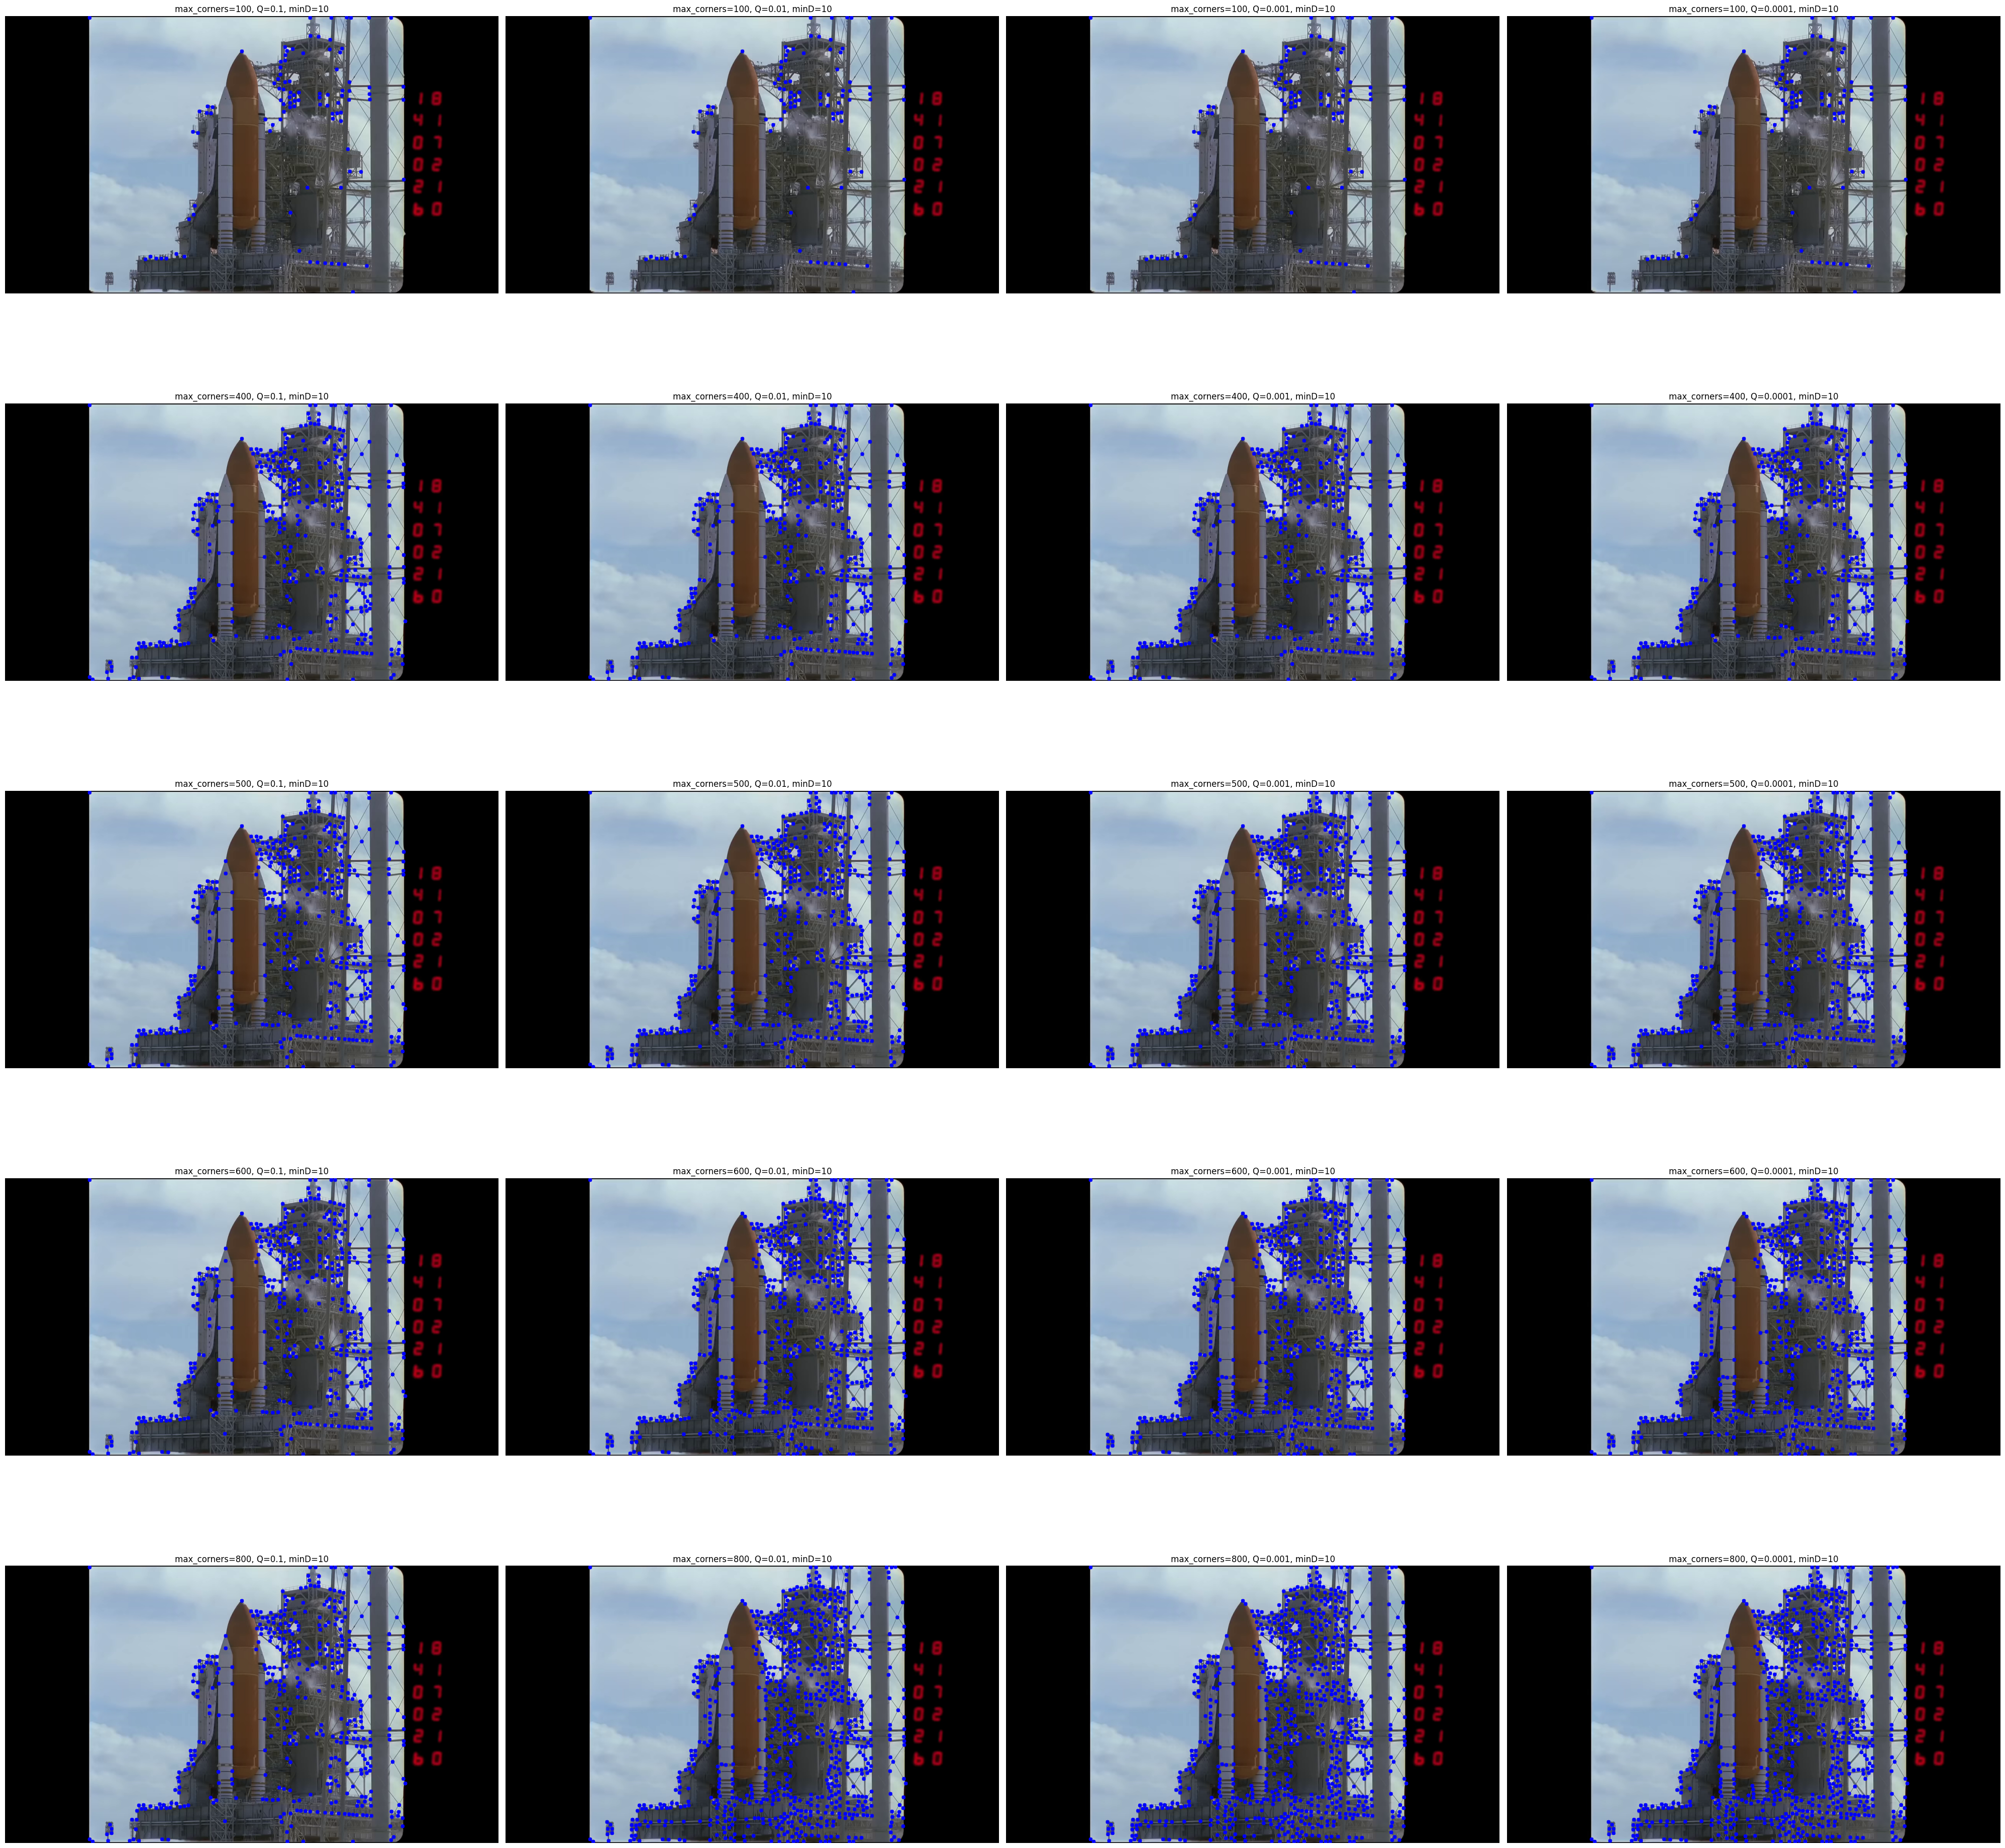

In [ ]:
max_corners = [100, 400, 500, 600, 800]
quality_levels = [0.1, 0.01, 0.001, 0.0001]

fig, axs = plt.subplots(len(max_corners), len(quality_levels), figsize=(40, 40))

for i, m_c in enumerate(max_corners):
  for j, q in enumerate(quality_levels):

    c, res_frame = find_features(frame, m_c, q, 10)

    axs[i, j].imshow(cv2.cvtColor(res_frame, cv2.COLOR_BGR2RGB))
    axs[i, j].set_title(f'max_corners={m_c}, Q={q}, minD=10')
    axs[i, j].axis('off')

plt.tight_layout()

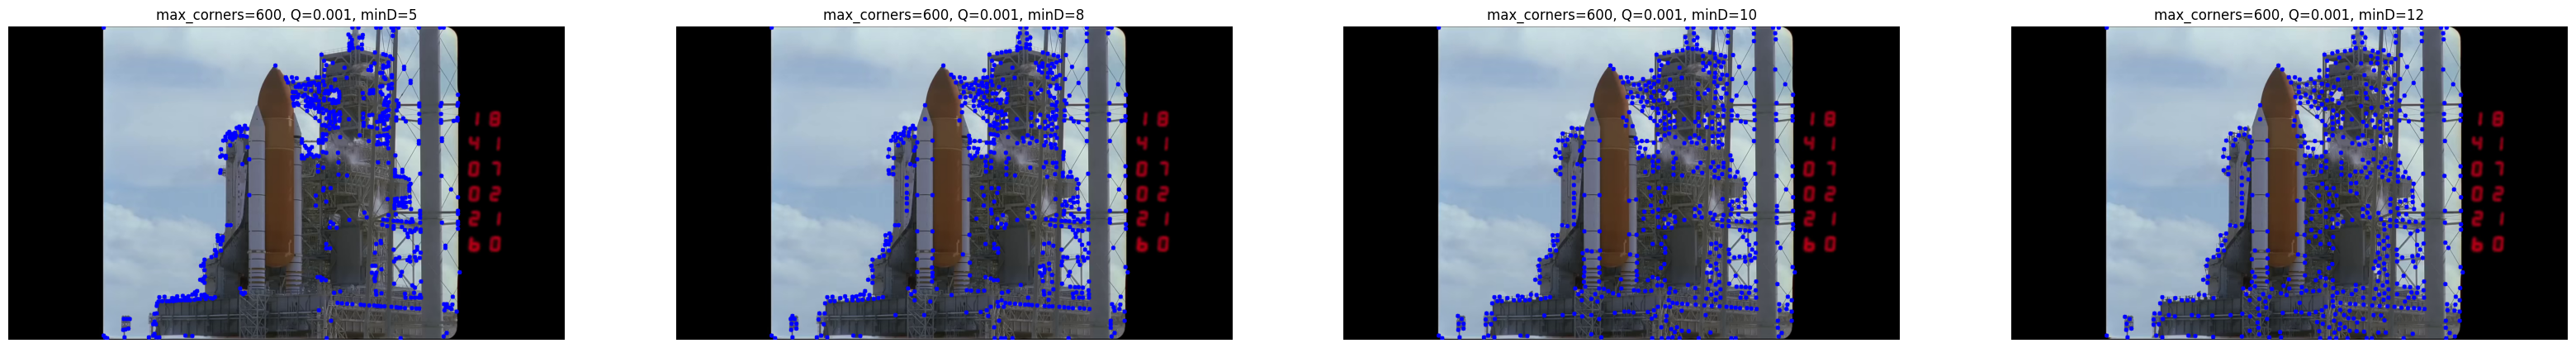

In [ ]:
mid_distances = [5, 8, 10, 12]

fig, axs = plt.subplots(1, len(mid_distances), figsize=(40, 40))

for i, d in enumerate(mid_distances):
  c, res_frame = find_features(frame, 600, 0.01, d)

  axs[i].imshow(cv2.cvtColor(res_frame, cv2.COLOR_BGR2RGB))
  axs[i].set_title(f'max_corners=600, Q=0.001, minD={d}')
  axs[i].axis('off')

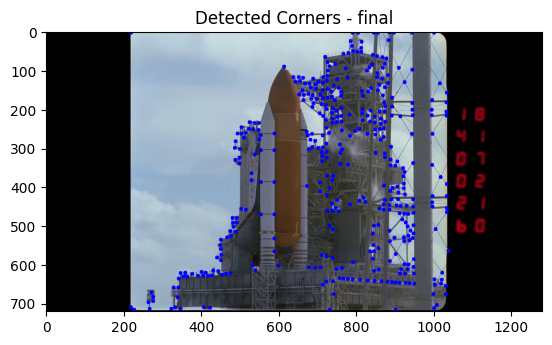

In [ ]:
features, res_frame_final = find_features(frame, 400, 0.1, 10)

plt.imshow(cv2.cvtColor(res_frame_final, cv2.COLOR_BGR2RGB))
plt.title('Detected Corners - final')
plt.show()

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [ ]:
shuttle = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/shuttle.mp4')

fps_shuttle = shuttle.get(cv2.CAP_PROP_FPS)
total_frames_shuttle = int(shuttle.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'Number of frames: {total_frames_shuttle}\nfps: {fps_shuttle}')

start_frame = int(total_frames_shuttle / 3)

shuttle.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

status, frame_start = shuttle.read()

Number of frames: 360
fps: 29.97


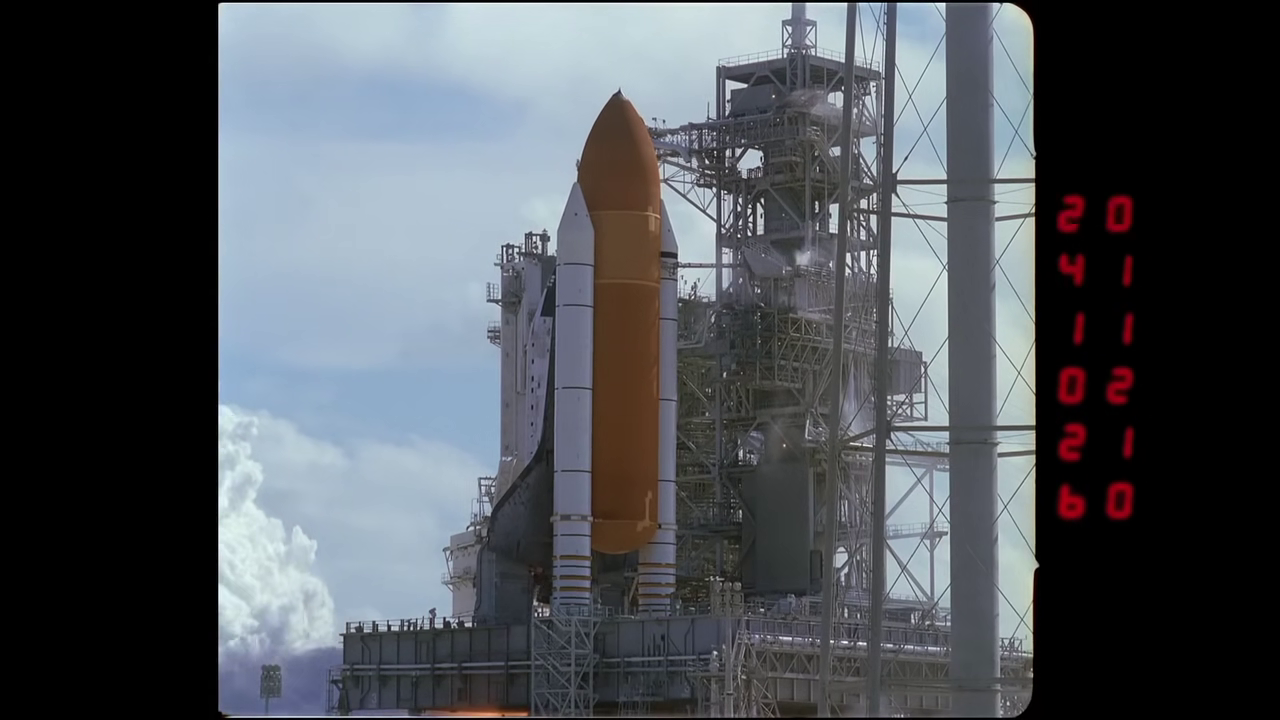

In [ ]:
cv2_imshow(frame_start)

In [ ]:
shuttle = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/shuttle.mp4')

In [ ]:
def baseLoop(source: cv2.VideoCapture):

    source.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    status, frame1 = source.read()
    frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

    feature_params = dict(max_corners=400, quality_level=0.1, min_distance=10)
    p0, res_img = find_features(frame1, **feature_params)

    mask = np.zeros_like(frame1)

    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    color = np.random.randint(0, 255, (400, 3))

    # Trajektorie
    trajectories = [[] for _ in range(len(p0))]

    n_f = 0

    while status and n_f < 150:

        status, frame2 = source.read()
        n_f+=1

        if not status:
            print('No more frames!')
            break

        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        p1, st, err = cv2.calcOpticalFlowPyrLK(frame1_gray, frame2_gray, p0, None, **lk_params)

        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]

            # Punkty do śmieci
            points_to_remove = [i for i, status in enumerate(st) if status == 0]
            for i in points_to_remove:
                del trajectories[i]

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
            frame2 = cv2.circle(frame2, (int(a), int(b)), 5, color[i].tolist(), -1)

            trajectories[i].append((int(a), int(b)))

        img = cv2.add(frame2, mask)

        frame1_gray = frame2_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

    trajectory_arrays = [np.array(trajectory, dtype=np.int32) for trajectory in trajectories]

    img_plane = frame_start.copy()

    for i, trajectory in enumerate(trajectory_arrays):
        cv2.polylines(img_plane, [trajectory], isClosed=False,
                      color = color[i].tolist(), thickness=1)

    return trajectory_arrays, img, img_plane

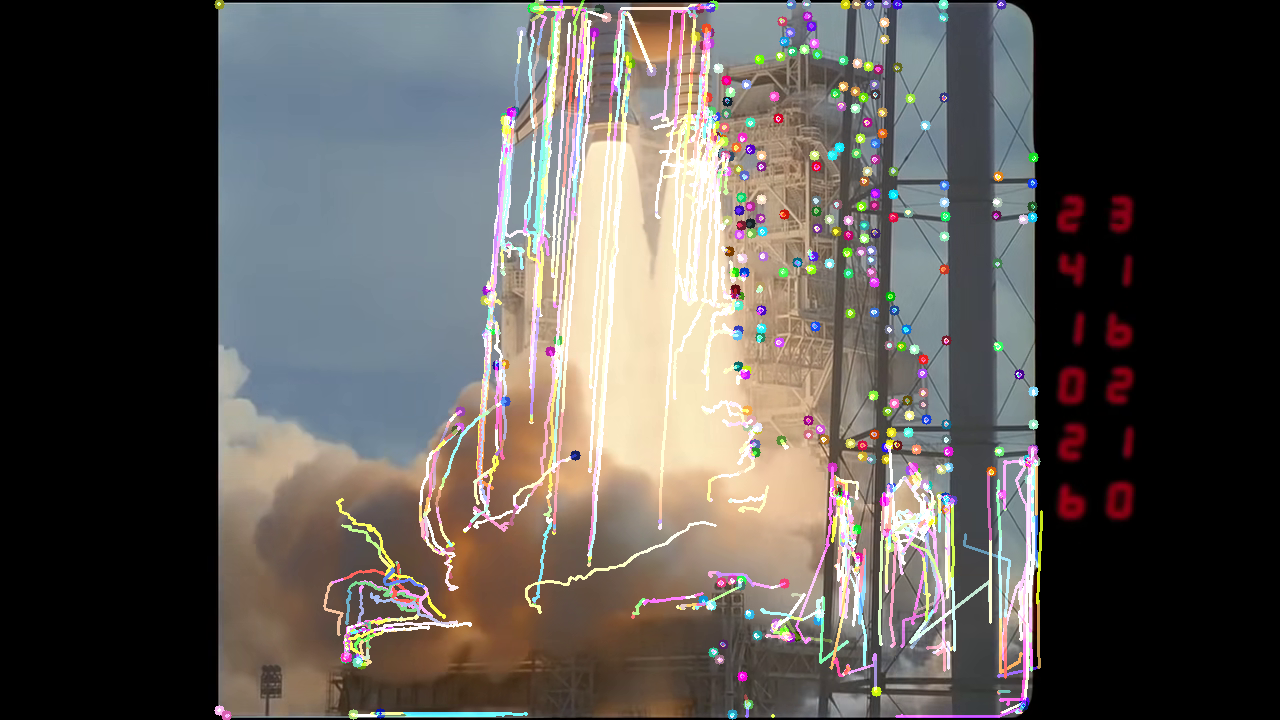

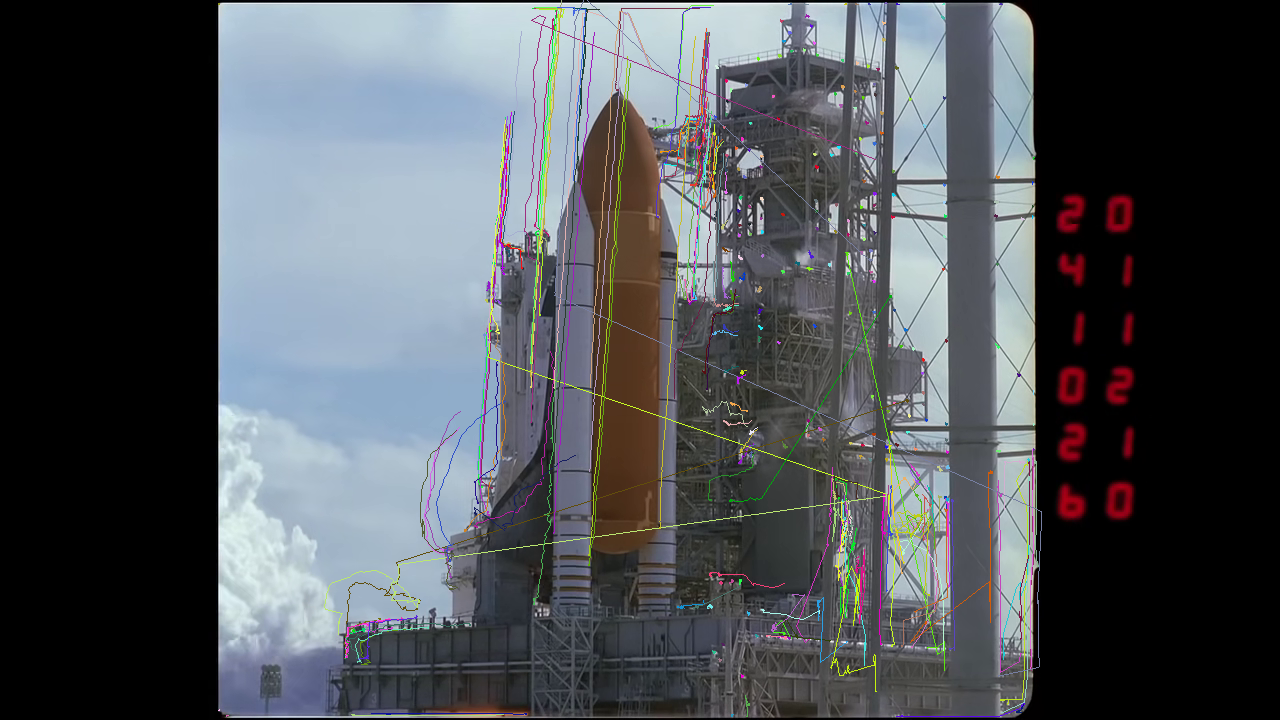

In [ ]:
shuttle = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/shuttle.mp4')

trajectories, img, img_plane = baseLoop(shuttle)
cv2_imshow(img)
cv2_imshow(img_plane)
shuttle.release()

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość Discovery. Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością. Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.

Bonus dla chętnych: czy na podstawie tego materiału da się wyznaczyć TWR (thrust-to-weight ratio) maszyny?

In [ ]:
import plotly.express as px
import pandas as pd

In [ ]:
def trajectory_length(trajectory):
    return np.linalg.norm(trajectory[-1] - trajectory[0])

In [ ]:
sorted_trajectories = sorted(trajectories, key=trajectory_length, reverse=True)

In [ ]:
lengths = [trajectory_length(trajectory) for trajectory in trajectories]

fig = px.histogram(x=lengths, nbins=80, title='Histogram Długości Trajektorii',
                   labels={'x': 'Długość trajektorii'}, width=800)

fig.show()

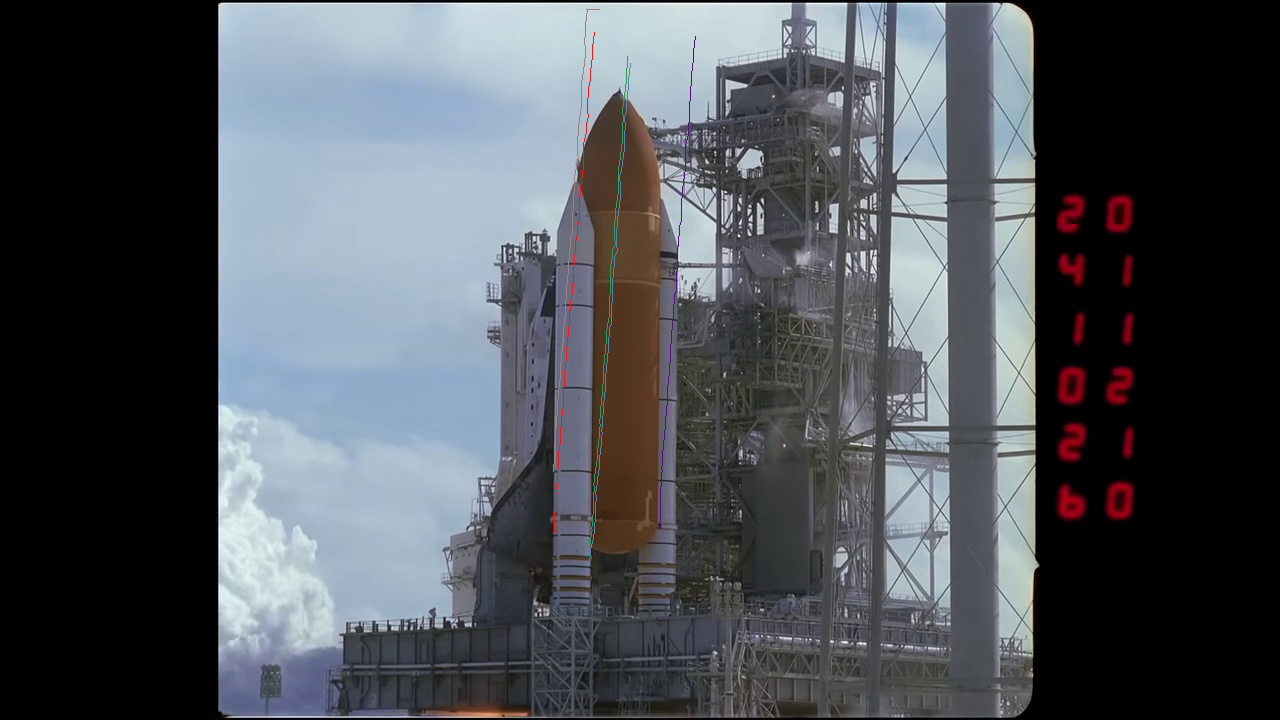

In [ ]:
real_trajectories = sorted_trajectories[3:8]

color = np.random.randint(0, 255, (len(real_trajectories), 3))

base = frame_start.copy()

for i, trajectory in enumerate(real_trajectories):
  cv2.polylines(base, [trajectory], isClosed=False,
                color = color[i].tolist(), thickness=1)
cv2_imshow(base)

each SRB is 149.16 feet long ≈ **45.463968** [m]

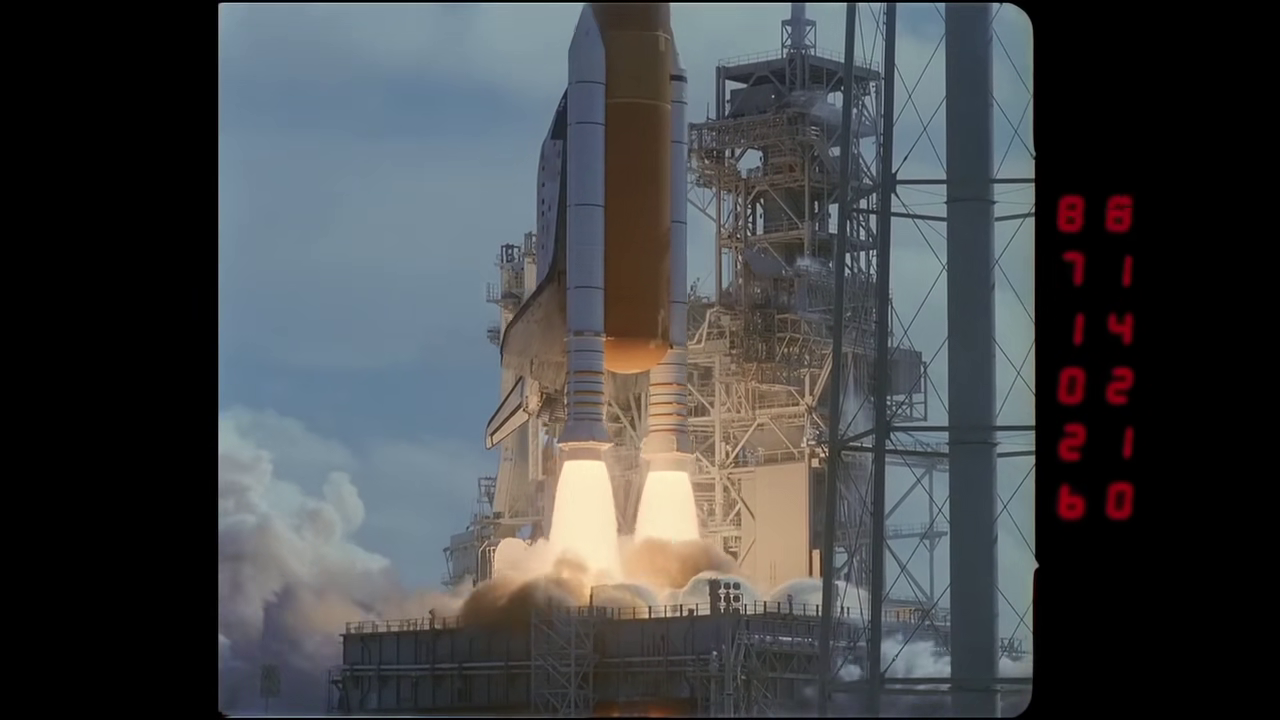

In [ ]:
# Wybranie klatki do przyrównania długości SRB

shuttle = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/shuttle.mp4')

fps_shuttle = shuttle.get(cv2.CAP_PROP_FPS)
total_frames_shuttle = int(shuttle.get(cv2.CAP_PROP_FRAME_COUNT))

half_frame = int(total_frames_shuttle / 2)

shuttle.set(cv2.CAP_PROP_POS_FRAMES, 221)

status, frame_221 = shuttle.read()

cv2_imshow(frame_221)

In [ ]:
frame_221.shape

(720, 1280, 3)

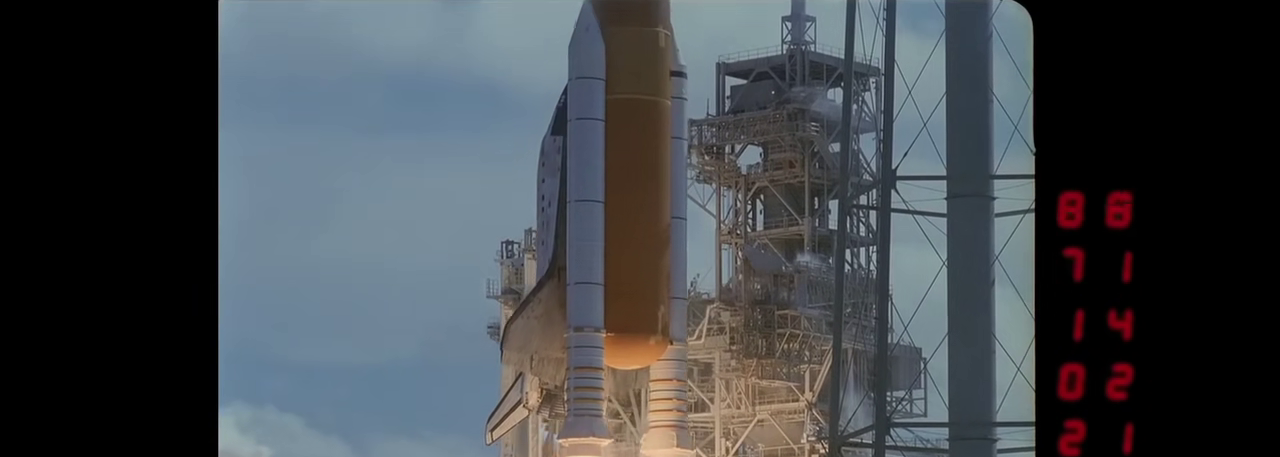

(457, 1280, 3)


In [ ]:
cropped_frame = frame_221[4:461, :]

cv2_imshow(cropped_frame)
print(cropped_frame.shape)

SRB_h = cropped_frame.shape[0]

In [ ]:
heigh_m = 45.463968
heigh_pix = SRB_h

len_pixel = heigh_m / heigh_pix

print(f'Pixel to meter ratio: {len_pixel}')

Pixel to meter ratio: 0.09948351859956236


In [ ]:
len(real_trajectories)

5

In [ ]:
def calculate_v(trajectory, len_pixel, fps_org, slowdown_ratio):
    # długość trwania klatki
    frame_time = 1 / (fps_org * slowdown_ratio)

    vs = []  # prędkości

    for i in range(1, len(trajectory)):

        delta = trajectory[i] - trajectory[i-1]
        distance_pix = trajectory_length(delta)

        v = distance_pix * len_pixel / frame_time
        vs.append(v)

    return vs

In [ ]:
fps_org = 225  # Oryginalna prędkość klatek na sekundę
slowdown_ratio = 1 / 7.5  # Spowolnienie

data = {'Time [s]': [], 'Velocity [m/s]': [], 'Trajectory': []}

for i, trajectory in enumerate(real_trajectories):
    velocities = calculate_v(trajectory, len_pixel, fps_org, slowdown_ratio)
    time = [frame / (fps_org * slowdown_ratio) for frame in range(len(velocities))]

    data['Time [s]'].extend(time)
    data['Velocity [m/s]'].extend(velocities)
    data['Trajectory'].extend([f'Trajectory {i + 1}'] * len(time))

df = pd.DataFrame(data)

fig = px.line(df, x='Time [s]', y='Velocity [m/s]', color='Trajectory',
              title='Wykres liniowy prędkości dla każdej trajektorii')
fig.show()

In [ ]:
avg_v = df[df['Trajectory'].isin(['Trajectory 1', 'Trajectory 2',
                                  'Trajectory 3', 'Trajectory 4'])].groupby('Time [s]')['Velocity [m/s]'].mean()
fig = px.line(x=avg_v.index, y=avg_v.values, title='Średnia prędkość (Trajectory 1-4)',
              labels={'x': 'Czas [s]', 'y': 'Prędkość [m/s]'},)

fig.show()

https://www1.grc.nasa.gov/beginners-guide-to-aeronautics/thrust-to-weight-ratio/

In [ ]:
import scipy.constants as const

g = const.g  #[m/s^]
m = 2030000  # [kg]
d_v = 28.86  # [m/s]
d_t = 4.93  # [s]

In [ ]:
TWR = (d_v / d_t) / g

In [ ]:
print(f'TWR={TWR}')

TWR=0.5969373206195338
